In [404]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from sklearn.cluster import MiniBatchKMeans, KMeans
import setGPU
import numpy as np
import h5py

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import setGPU

import sys,os
#sys.path.append(os.path.abspath(os.path.join('../ADgvae/')))
from pathlib import Path
from importlib import reload  
import os.path as osp
sys.path.append(os.path.abspath(os.path.join('IDEC/')))
import idec_graph as idec_mod
reload(idec_mod)
from idec_graph import IDEC
import IDEC.utils as utils_idec
reload(utils_idec)
from scipy.sparse import csr_matrix

from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data, Batch, DataLoader
from IDEC.utils import GraphDataset, cluster_acc
from torch_scatter import scatter_mean,scatter_max

from sklearn.manifold import TSNE

import matplotlib.colors as colors

In [405]:
DATA_PATH = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/inputs/'
TRAIN_NAME = 'background_chan3_passed_ae_l1.h5'
#TRAIN_NAME = 'bkg_sig_0.0156_l1_filtered.h5'
filename_bg = DATA_PATH + TRAIN_NAME 
in_file = h5py.File(filename_bg, 'r') 
file_dataset = np.array(in_file['dataset'][:,:,:])
#file_dataset=file_dataset[:,:,[0,2,4,5,6,7]] #exclude dkl and charge for now
file_dataset[:,:,2] = file_dataset[:,:,2]/1e5
file_dataset[:,:,3] = file_dataset[:,:,3]/1e5

n_proc = 3
(unique, counts) = np.unique(file_dataset[:,:,0], return_counts=True)
procs_sorted, counts_sorted = zip(*sorted(zip(unique, counts), key=lambda x: x[1],reverse=True))
top_proc_mask = np.isin(file_dataset[:,0,0], procs_sorted[:n_proc]) #choose top 3
file_dataset = file_dataset[top_proc_mask][:,0:12,:]
file_dataset[:,:,2] = np.log(file_dataset[:,:,2]+1)
file_dataset[:,:,3] = np.log(file_dataset[:,:,3]+1)

datas = []
tot_evt =  file_dataset.shape[0]# int(1e4)
print('Preparing the dataset of {} events'.format(tot_evt))
n_objs = 11
#adj = [csr_matrix(np.ones((n_objs,n_objs)) - np.eye(n_objs))]*tot_evt
#edge_index = [from_scipy_sparse_matrix(a)[0] for a in adj]     
adj_non_con = make_adjacencies(file_dataset[:,1:,:])
adj_non_connected = [csr_matrix(adj_non_con[i]) for i in range(tot_evt)]
edge_index = [from_scipy_sparse_matrix(a)[0] for a in adj_non_connected] 

x = [torch.tensor(file_dataset[i_evt,1:,1:], dtype=torch.float) for i_evt in range(tot_evt)]
y = [torch.tensor(int(file_dataset[i_evt,0,0]), dtype=torch.int) for i_evt in range(tot_evt)]
met = [torch.tensor(file_dataset[i_evt,0,[2,5]], dtype=torch.float) for i_evt in range(tot_evt)]
datas = [Data(x=x_event, edge_index=edge_index_event,y=torch.unsqueeze(y_event, 0),x_met=met_event) 
    for x_event,edge_index_event,y_event,met_event in zip(x,edge_index,y,met)]
print('Dataset of {} events prepared'.format(tot_evt))
dataset  = GraphDataset(datas)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


Preparing the dataset of 62305 events
Dataset of 62305 events prepared


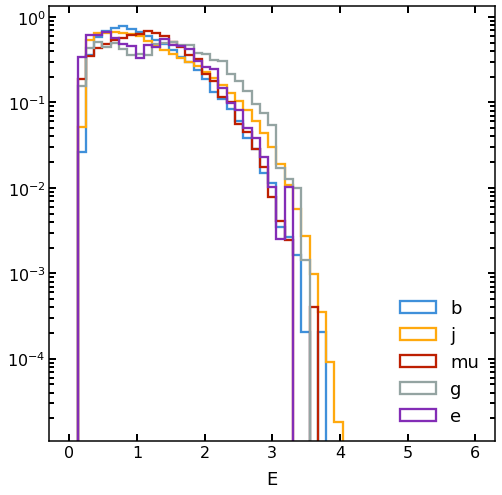

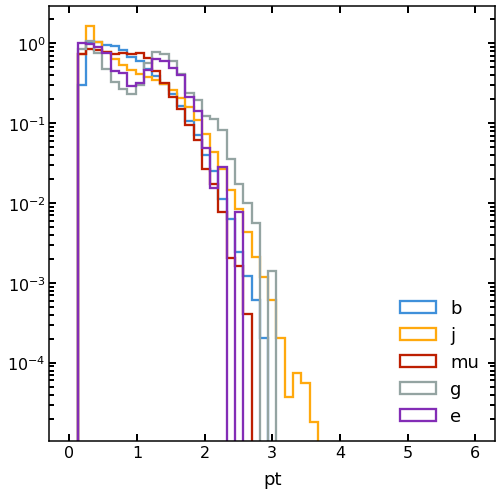

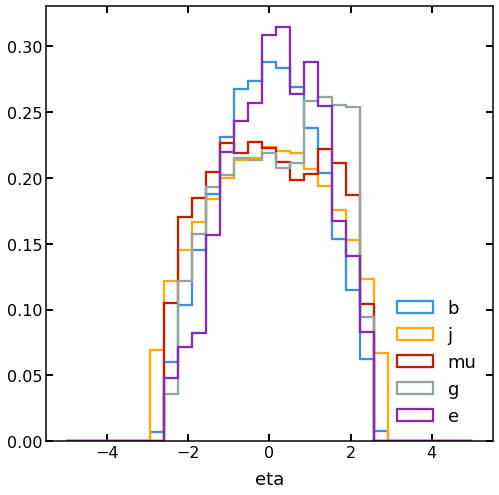

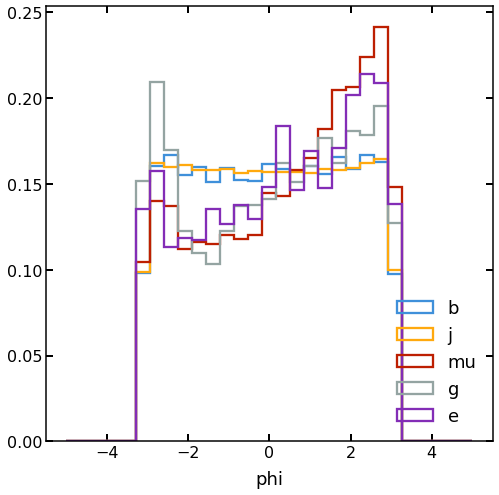

In [403]:
for i,name in zip([2,3,4,5],'E,pt,eta,phi'.split(',')):
    plt.figure(figsize=(8,8))
    bins = np.linspace(-5,5,30)
    if i==2 or i==3:
        bins = np.linspace(0,6,50)
        plt.semilogy()
    kwargs={'linewidth':2.3, 'fill':False, 'density':True,'histtype':'step'}
    for pid_name, pid in zip(['b','j','mu','g','e'],[1,2,3,4,5]):
        _ = plt.hist(file_dataset[:,1:,i][file_dataset[:,1:,1]==pid],bins=bins,**kwargs,label=pid_name)
    plt.xlabel(name)
    plt.legend(loc='lower right')

In [406]:
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


num_clusters_dict = {}

for num_cluster in [3]:  
    model = IDEC(input_shape = [11,5], 
                hidden_channels = [10, 12, 16, 20,30],
                latent_dim =5,
                n_clusters=num_cluster,
                alpha=1,
                pretrain_path='data_graph/graph_ae_pretrain.pkl'
    ).to(device)

    model.load_state_dict(torch.load(
"/eos/user/n/nchernya/MLHEP/AnomalyDetection/AnomalyClustering/IDEC/data_graph/graph_ae_pretrain_top_3_emb_log_real_part_huber_met_energy_fullmodel_num_clust_{}.pkl".format(num_cluster)))

    batch_size=256
    test_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    latent_pred = []
    true_labels = []
    model.eval() 
    
    pred_features = np.array([model.forward(d.to(device))[0].data.cpu().numpy() for i,d in enumerate(test_loader)]) 
    pred_features_met = np.array([model.forward(d.to(device))[1].data.cpu().numpy() for i,d in enumerate(test_loader)]) 
    emb_input = []  
    #for i,d in enumerate(test_loader):
    #    model.forward(d.x.to(device),d.edge_index.to(device),d.batch.to(device))
    #    emb_input.append(model.ae.embedded_input.detach().cpu())
    #emb_input = np.array(emb_input)

    acc, nmi, ari,reassignment, true_labels, pred_labels, latent_pred  = model.validateOnCompleteTestData(test_loader)

    print('Acc {:.4f}'.format(acc),
        ', nmi {:.4f}'.format(nmi), ', ari {:.4f}'.format(ari))
    predicted_reassigned = np.array([reassignment[item] for item in pred_labels])
    
    idx = np.random.choice(list(range(latent_pred.shape[0])), 3000)
    num_clusters_dict[num_cluster] = {}
    num_clusters_dict[num_cluster]['sil_score'] = silhouette_score(latent_pred[idx], predicted_reassigned[idx])
    num_clusters_dict[num_cluster]['db_score'] = davies_bouldin_score(latent_pred[idx], predicted_reassigned[idx])
    num_clusters_dict[num_cluster]['ch_score'] = calinski_harabasz_score(latent_pred[idx], predicted_reassigned[idx])

    

/afs/cern.ch/user/n/nchernya/.local/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Acc 0.3888 , nmi 0.0004 , ari -0.0015


In [407]:


#t = file_dataset[:int(1e3),:,2:]
#t = t.reshape((t.shape[0])*t.shape[1],t.shape[2])

#t = np.vstack(emb_input)

t = file_dataset[:int(1e4),1:,1:]
t = t.reshape((t.shape[0])*t.shape[1],t.shape[2])

pred_features = np.array([model.forward(d.to(device))[0].data.cpu().numpy() for i,d in enumerate(test_loader)]) 
pred_features_small = pred_features[:,:,4:]

pr_f = np.expand_dims(np.argmax(np.exp(pred_features[:,:,0:4]),axis=-1),axis=-1)
pred_features_small = np.concatenate([pr_f,pred_features[:,:,4:]],axis=-1)

pred_features_2 = pred_features_small.reshape((pred_features_small.shape[0])*pred_features_small.shape[1],pred_features_small.shape[2])

t_met = file_dataset[:,0:1,[2,5]]
t_met = t_met.reshape((t_met.shape[0])*t_met.shape[1],t_met.shape[2])
pred_met = pred_features_met.reshape((pred_features_met.shape[0]*pred_features_met.shape[1],pred_features_met.shape[2]))

    

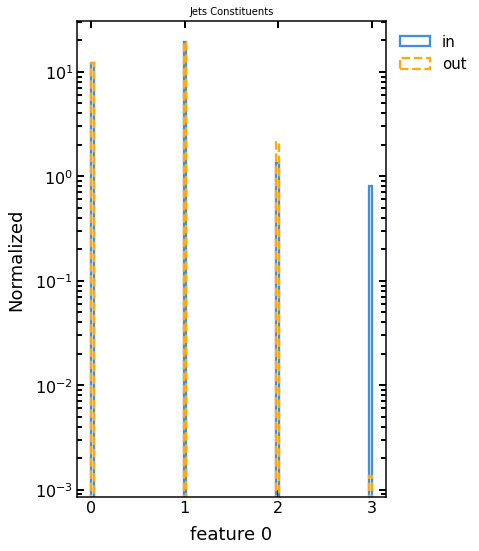

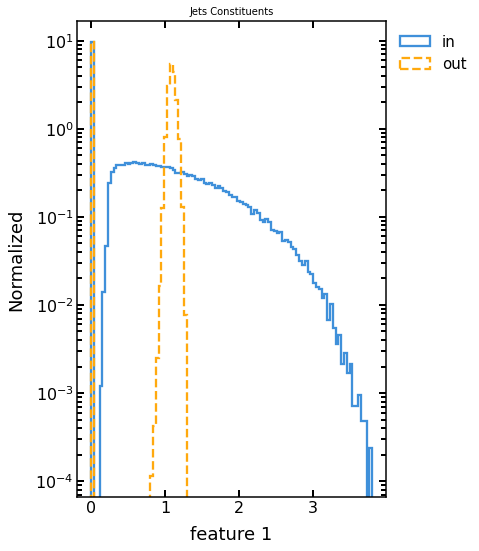

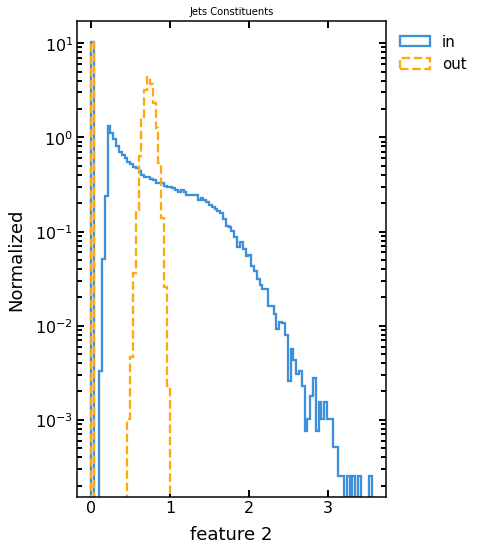

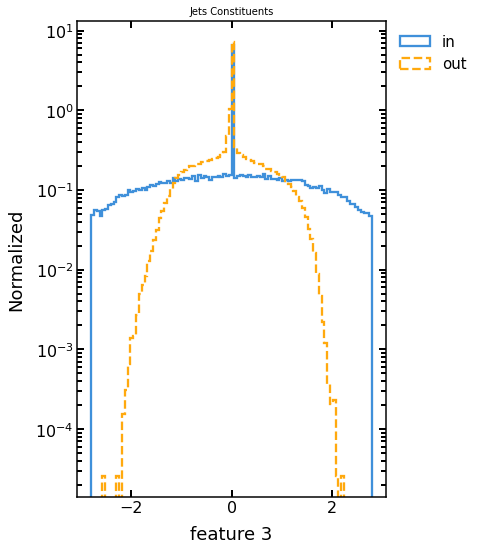

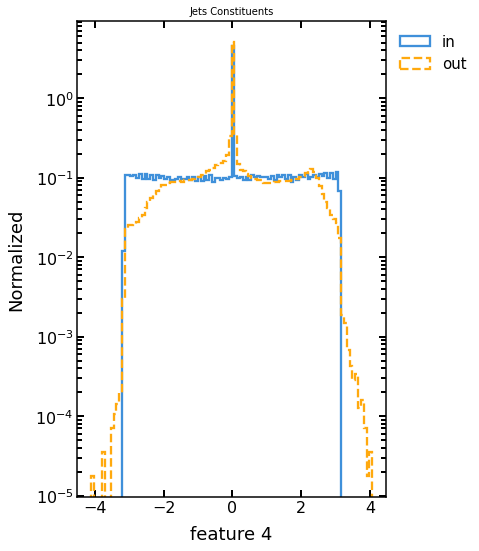

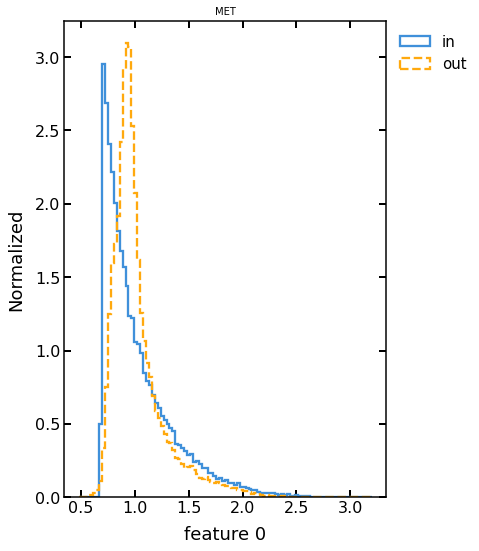

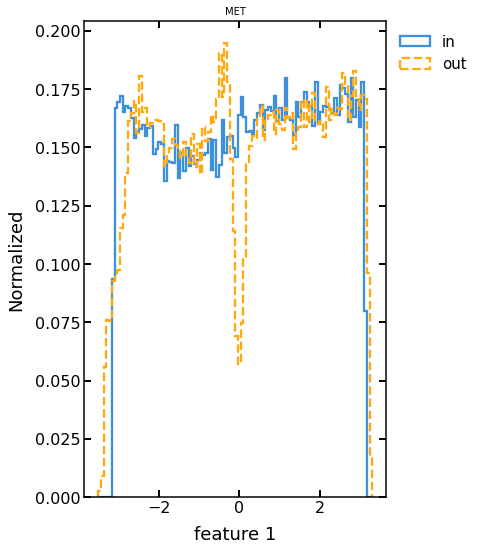

In [408]:
sys.path.append(os.path.abspath(os.path.join('../')))
import vande.util.util_plotting as vande_plot
reload(vande_plot)


vande_plot.plot_features([t,pred_features_2], 'feature' ,
                             'Normalized' , 'Jets Constituents', 
                             plotname='test',
                             legend=['in','out'],
                              ylogscale=True)
    
vande_plot.plot_features([t_met,pred_met], 'feature' ,
                             'Normalized' , 'MET', 
                             plotname='test',
                             legend=['in','out'],
                              ylogscale=False)

In [205]:
X_embedded = TSNE(n_components=2,verbose=1, perplexity=20, n_iter=1000, learning_rate=200
                 ).fit_transform(latent_pred[idx])

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.002s...
[t-SNE] Computed neighbors for 3000 samples in 0.043s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.431212
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.782272
[t-SNE] KL divergence after 1000 iterations: 1.154727


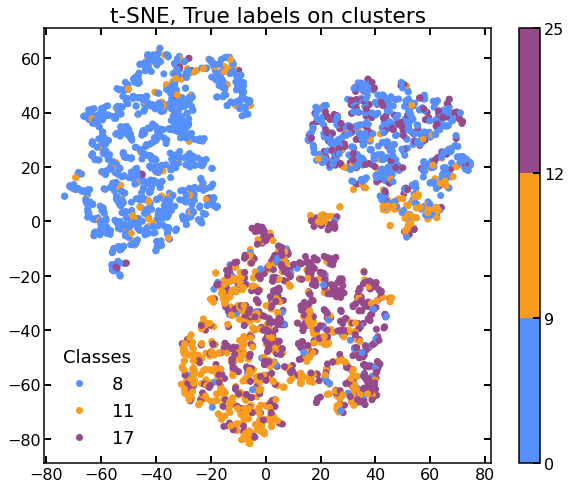

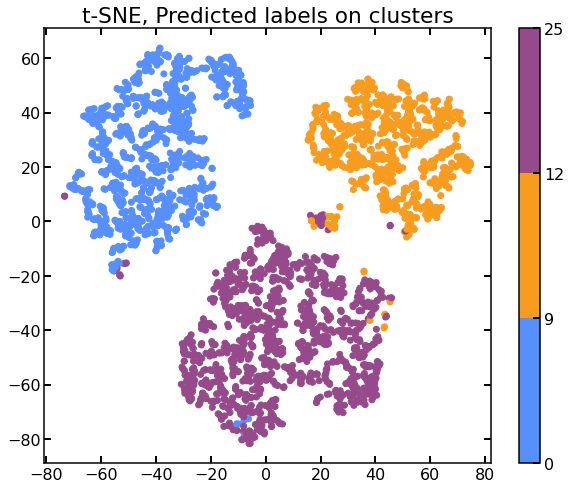

In [206]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')


cmap = plt.cm.rainbow #rainbow
cmap = (colors.ListedColormap(['#5790fc', '#f89c20', '#e42536', '#964a8b'])
        .with_extremes(over='0.25', under='0.75'))
#norm = colors.BoundaryNorm(np.arange(1, 26, 1), cmap.N)
norm = colors.BoundaryNorm([0,9,12,25], cmap.N)

fig = plt.figure(figsize=(10,8))

#top_proc_mask = np.isin(true_labels[idx], result1[:5])
scatter = plt.scatter(X_embedded[:,0],X_embedded[:,1], c=true_labels[idx],cmap=cmap, norm=norm)
plt.title('t-SNE, True labels on clusters')
cb = plt.colorbar()
# produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

#ax.add_artist(legend1)


fig = plt.figure(figsize=(10,8))
plt.scatter(X_embedded[:,0],X_embedded[:,1], c=np.array(predicted_reassigned)[idx],cmap=cmap, norm=norm)
plt.title('t-SNE, Predicted labels on clusters')
cb = plt.colorbar()

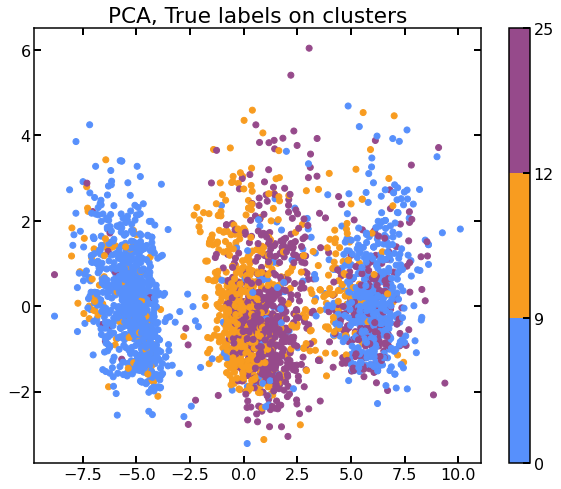

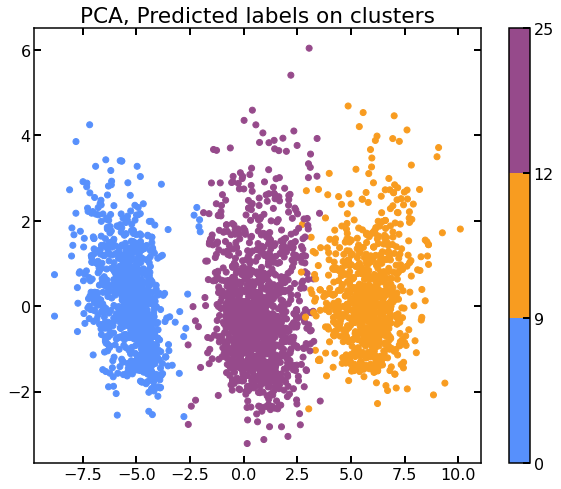

In [207]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import colors


pca = PCA(n_components=2)
principalComponents = pca.fit_transform(np.array(latent_pred))

pc1 = principalComponents[:,0][idx]
pc2 = principalComponents[:,1][idx]




fig = plt.figure(figsize=(10,8))
plt.scatter(pc1,pc2, c=true_labels[idx],cmap=cmap, norm=norm, marker='o')
plt.title('PCA, True labels on clusters')
cb = plt.colorbar()



fig = plt.figure(figsize=(10,8))
plt.scatter(pc1,pc2, c=predicted_reassigned[idx],cmap=cmap, norm=norm)
plt.title('PCA, Predicted labels on clusters')
cb = plt.colorbar()



In [491]:
np.unique(np.argmax(pred_features[:,:,0:5],axis=-1))

array([0, 1])

In [173]:
#pred_features = np.array([model.forward(d.x.to(device),d.edge_index.to(device),d.batch.to(device))[0].data.cpu().numpy() for i,d in enumerate(test_loader)]) 


test_loader_2 = DataLoader(
        dataset, batch_size=2000, shuffle=False, drop_last=True)
for i,d in enumerate(test_loader_2):
    #out = model.forward(d.x.to(device),d.edge_index.to(device),d.batch.to(device))
    #log_soft_max  = nn.LogSoftmax(dim=-1)
    #print(d.x)
    #x_cat = np.exp(log_soft_max(d.x))
    #print(x_cat)
    #break
    #print(d.x)
    print(d.x_met.reshape((2000,2)))
    if i==2 : break

    
    
    

tensor([[ 0.7358, -0.5529],
        [ 2.1617, -1.2650],
        [ 1.2736,  0.1329],
        ...,
        [ 1.3163,  2.7818],
        [ 1.0090, -0.5634],
        [ 0.8190, -2.7089]])
tensor([[ 1.2872, -2.4122],
        [ 0.8234, -2.4045],
        [ 0.8199, -1.7819],
        ...,
        [ 0.7839,  2.9189],
        [ 1.0168,  2.2358],
        [ 1.0915,  1.9199]])
tensor([[ 1.6661,  2.8324],
        [ 0.8713,  2.1404],
        [ 0.7197,  1.2670],
        ...,
        [ 0.7586, -2.0651],
        [ 0.8410,  0.4610],
        [ 0.7496, -1.2040]])


In [614]:
unique, counts = np.unique(d.x[:,0], return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
print(np.max(frequencies[:,-1])/frequencies[:,-1])
print(frequencies[:,-1]/np.sum(frequencies[:,-1]))

[[0.0000e+00 1.7909e+04]
 [1.0000e+00 1.2707e+04]
 [2.0000e+00 8.4600e+02]
 [3.0000e+00 5.3800e+02]
 [4.0000e+00 2.0000e+03]]


In [41]:
def eppt_to_xyz(pt, eta, phi):
    px = pt*np.cos(phi) 
    py =  pt*np.sin(phi)
    pz = pt * np.sinh(eta)
    e = np.sqrt(np.square(pt)+np.square(pz)) #no mass, mass = 0
    return e,px,py,pz


file_dataset = file_dataset_orig[:,0:1,:]
mask = (file_dataset[:,:,2]>0.25) & (file_dataset[:,:,3]>0.25) & (file_dataset[:,:,1]==1) & (file_dataset[:,:,0]==17)
rear_first = np.stack([file_dataset[:,:,2][mask],file_dataset[:,:,3][mask],file_dataset[:,:,4][mask],file_dataset[:,:,5][mask]],axis=-1)
                  
jet1_e,jet1_px,jet1_py,jet1_pz = eppt_to_xyz( file_dataset[:,:,2][mask], file_dataset[:,:,4][mask], file_dataset[:,:,3][mask])
rear_second = np.stack([jet1_e,jet1_px,jet1_py,jet1_pz],axis=-1)
#np.expand_dims(jet1_e,-1),np.expand_dims(jet1_px,-1),np.expand_dims(jet1_py,-1),np.expand_dims(jet1_pz,-1)]

rear = np.concatenate([rear_first,rear_second],axis=-1)
for i in range(rear.shape[-1]):
    plt.figure(figsize=(10,8))
    bins = np.linspace(-50, 50, 100)
    if i==2 or i==3 :#or i==5 or i==6:
        bins = np.linspace(-3, 3, 100)
    plot = plt.hist(rear[:,i],bins=bins)
   # plt.semilogy( )

3.141592653589793